# AIPI 590 - XAI | Assignment #3
## Explainable Techniques I
### Shaunak Badani


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shaunak-badani/XAI/blob/main/Assignment02/InterpretableML.ipynb)

In [1]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings
import matplotlib.pyplot as plt

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)



2025-01-25 12:45:34.979419: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Notebook running: keras  2.12.0


## LIME with the Inception model

- In this notebook, the LIME explainability method is used, along with the pre-trained inception model.
- LIME was chosen because of it's simplistic nature and intuitive algorithm, which uses local perturbations to help understand which features of the input were the most intrumental in the prediction.

#### Pros:

- Flexible, model agnostic - you can use LIME with any model of any architecture.
- Intuitive.
- Works for any kind of data - text, images or tabular

#### Cons:
- It's limited on how to define a neighborhood and optimize it.
- The explanations are incosistent - they differ across settings and experiments.
- Can be used to hide biases and is easily fooled.

In [2]:
warnings.filterwarnings('ignore')
inceptionV3_model = keras.applications.inception_v3.InceptionV3() #Load pretrained model

2025-01-25 12:45:36.428288: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Example image to use on LIME

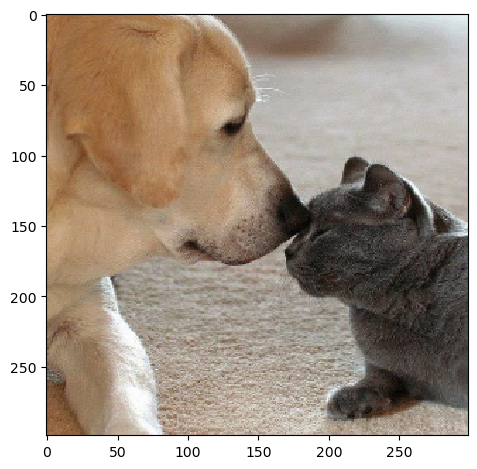

In [3]:
Xi = skimage.io.imread("https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg")
Xi = skimage.transform.resize(Xi, (299,299))
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

In [4]:
print("Top 5 predictions from the inception model for the image:")
np.random.seed(222)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
top_pred_classes = preds.argsort()[0][::-1][:5]
decode_predictions(preds)[0] #Top 5 classes

Top 5 predictions from the inception model for the image:
1/1 [==============================] - 1s 656ms/step


[('n02099712', 'Labrador_retriever', 0.82213134),
 ('n02099601', 'golden_retriever', 0.015566474),
 ('n02093428', 'American_Staffordshire_terrier', 0.009475728),
 ('n02108422', 'bull_mastiff', 0.00831732),
 ('n02109047', 'Great_Dane', 0.007830365)]

In [5]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

69

## Superpixels
Superpixels is an image of the same size as the cat-and-dog image. Superpixels gives each pixel a number, indicating which image segment they are a part of. As shown above, there are 69 unique values in the superpixels image, indicating that the image has been divided into 69 different parts.

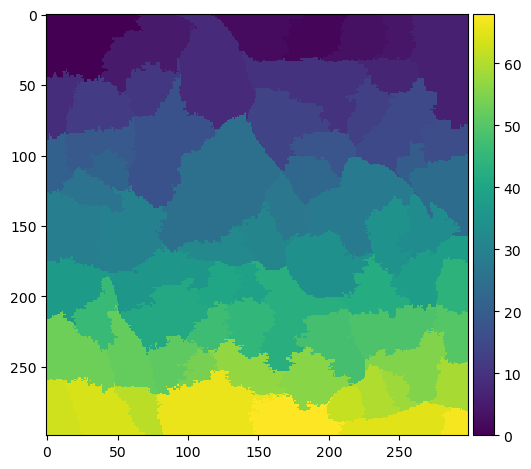

In [6]:
skimage.io.imshow(superpixels)

Using superpixels, we can mark boundaries at places where superpixels change numbers, indicating a change in the image segment.

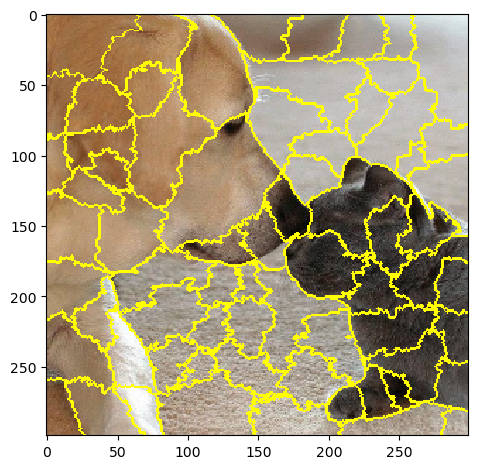

In [7]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

Using the superpixels, we will create 150 perturbations of the image.

Each perturbation is a 69-dimensional binary array.
[0 1 0 1 .... 1] 
indicates that the first segment is blacked out, the second segment is considered, the third segment is blacked out, and so on and so forth.

In [8]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1])

In [9]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

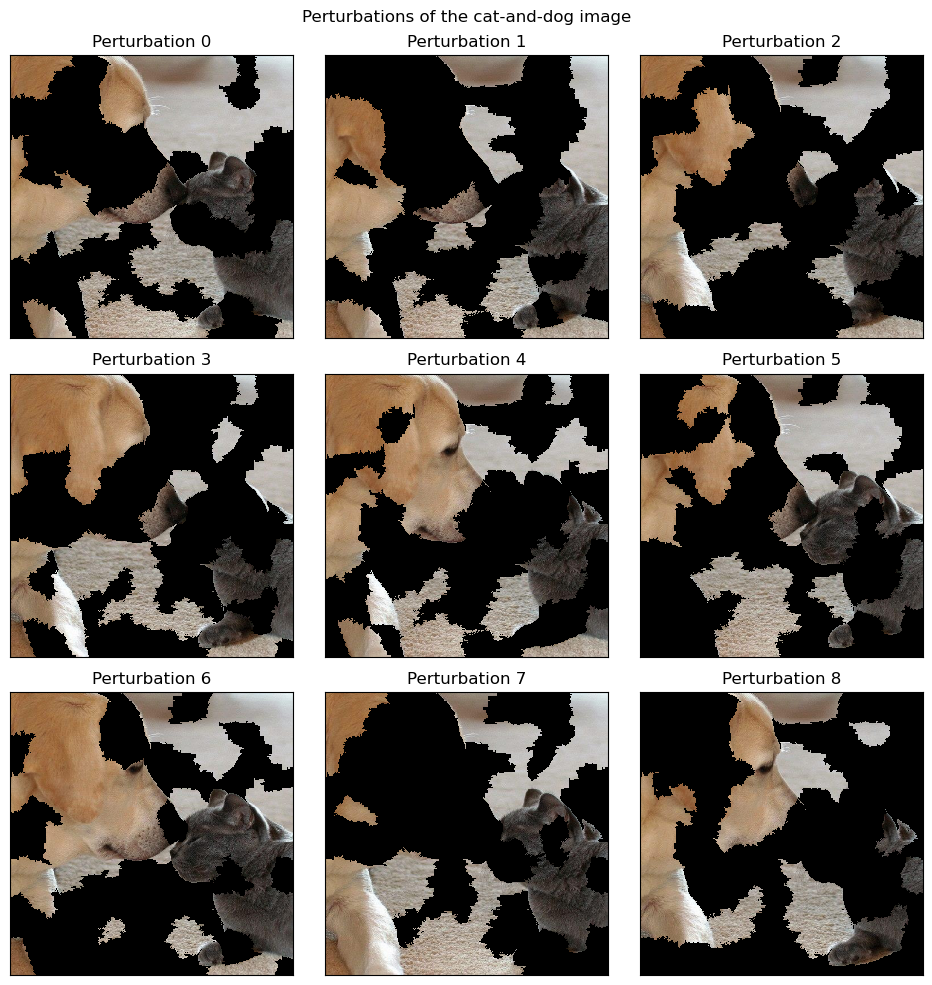

In [10]:
fig, axes = plt.subplots(3, 3, figsize = (10, 10), subplot_kw = {'xticks': [], 'yticks': []})
fig.suptitle("Perturbations of the cat-and-dog image")

for i, ax in enumerate(axes.flatten()):
  perturbed_image = perturb_image(Xi/2+0.5,perturbations[i],superpixels)
  skimage.io.imshow(perturbed_image , ax = ax)
  ax.set_title(f"Perturbation {i}")

In [11]:
predictions = []
perturbed_images = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  perturbed_images.append(perturbed_img)
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape



1/1 [==============================] - 0s 77ms/step


(150, 1, 1000)

In [12]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()

A cosine distance metric is calculated for each perturbation. This metric measures how far the perturbation is from the original image. 0 indicates that the images are identical, while 1 denotes maximum possible distances between the perturbation and the original.

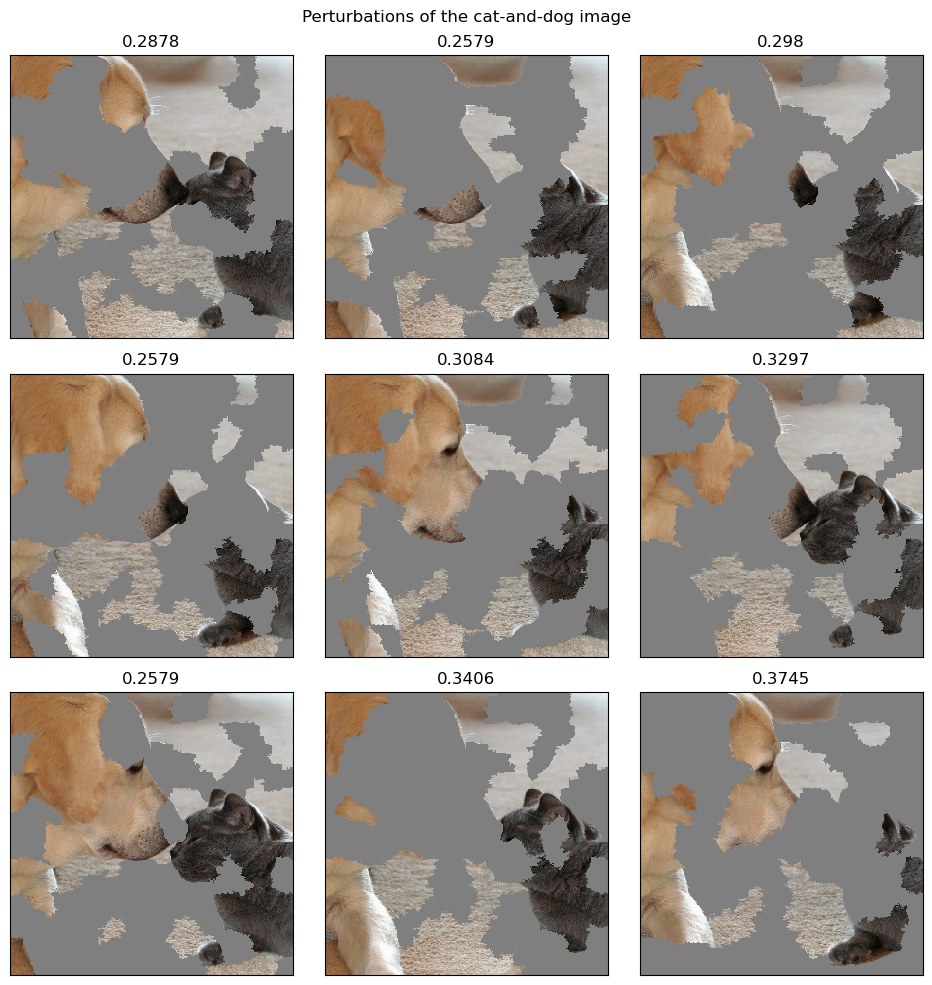

In [13]:
fig, axes = plt.subplots(3, 3, figsize = (10, 10), subplot_kw = {'xticks': [], 'yticks': []})
fig.suptitle("Perturbations of the cat-and-dog image")

for i, ax in enumerate(axes.flatten()):
  skimage.io.imshow(perturbed_images[i] / 2 + 0.5 , ax = ax)
  
  ax.set_title(f"{round(distances[i], 4)}")

Using these distances, we use a smoothing kernel function which will serve as inputs to our linear regression model

In [14]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function

A linear regression model is now fit, with the X value being the perturbed 69-dimensional vectors, indicating that there are 69 features. The predicted value is the probability with which the model predicted "Golden Retriever" for that perturbed image.

Each sample in the linear regression model has a weight equal to the kernel function applied with the distance. Higher weight implies more influence of the sample on the best fit line.

In [15]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]

So we obtain a coefficient vector of size 71. Find the indices of the coefficients with the highest coefficient value, and they indicate which superpixels were the most influential in predicting "Golden Retriever" in the image.

We use K = 4 in this example.

In [16]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:]
top_features

array([ 9, 26,  8, 25])

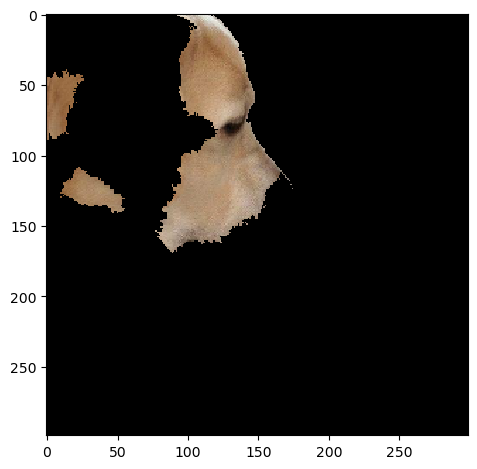

In [17]:
mask = np.zeros(num_superpixels)
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels))